
<center>
<h1> AWS SageMaker </h1>
    <h2>Scalable MLOps using AWS SageMaker </h2>
    <h3>July 18, 2023</h3>
<hr>
<h1>Exploratory Data Analysis</h1>
<hr>
 </center>

# **Introduction**
#### Non-default library installs

In [1]:
# !pip install -q autoviz
# !pip install -q -U --pre pycaret
# !pip uninstall umap
# !pip install umap-learn


#### Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import umap

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from autoviz.AutoViz_Class import data_cleaning_suggestions

from pycaret  import regression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor

c:\Users\kheri\anaconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\kheri\anaconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\kheri\anaconda3\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

Imported v0.1.730. After importing autoviz, execute '%matplotlib inline' to display charts inline.
    AV = AutoViz_Class()
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# **Loading and Understanding Data**
#### Connecting to the S3 Bucket

In [3]:
BUCKET_NAME = -1

RAW_DATA_FOLDER = '../Dataset/'
RAW_DATA_FILE = 'healthcare-dataset-stroke-data.csv'
RAW_DATA_PATH = os.path.join(RAW_DATA_FOLDER, RAW_DATA_FILE)

df = pd.read_csv(RAW_DATA_PATH)

## 1. Understanding composition of Data

This is done in the following way:
* Getting the dimension (# of entries and attributes)
* Finding the fraction of missing data
* Datatypes of non-primitives attributes

In [4]:
df.shape

(5110, 12)

This dataset contains 5110 entries and 12 different attributes, now to find the portion of missing data per attribute

In [5]:
(pd.DataFrame([df.isna().mean(), df.dtypes])
   .T
   .rename({0:'Fraction Missing',
            1:'DataType'}, axis=1))

Fraction Missing DataType
id                         0.0        int64
gender                     0.0       object
age                        0.0      float64
hypertension               0.0        int64
heart_disease              0.0        int64
ever_married               0.0       object
work_type                  0.0       object
Residence_type             0.0       object
avg_glucose_level          0.0      float64
bmi                   0.039335      float64
smoking_status             0.0       object
stroke                     0.0        int64

There are some variables that are of type 'Object', and some bmi entries missing. We will examine these further:

In [6]:
print("Number of empty entries for 'bmi' column: ", df['bmi'].isna().sum(), '\n')

print(df['gender'].head(1), '\n')
print(df['ever_married'].head(1), '\n')
print(df['work_type'].head(1), '\n')
print(df['Residence_type'].head(1), '\n')
print(df['smoking_status'].head(1), '\n')

Number of empty entries for 'bmi' column:  201 

0    Male
Name: gender, dtype: object 

0    Yes
Name: ever_married, dtype: object 

0    Private
Name: work_type, dtype: object 

0    Urban
Name: Residence_type, dtype: object 

0    formerly smoked
Name: smoking_status, dtype: object 



From these cells, we've ascertained that there are 5110 entries which possess 12 different attributes, some of which are categorical, and that 201 (3.93%) of the points are missing bmi values.

## 2. EDA


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
df.describe()

id           age      hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000   5110.000000    
mean   36517.829354    43.226614      0.097456      0.054012    
std    21161.721625    22.612647      0.296607      0.226063    
min       67.000000     0.080000      0.000000      0.000000    
25%    17741.250000    25.000000      0.000000      0.000000    
50%    36932.000000    45.000000      0.000000      0.000000    
75%    54682.000000    61.000000      0.000000      0.000000    
max    72940.000000    82.000000      1.000000      1.000000    

       avg_glucose_level      bmi        stroke     
count     5110.000000     4909.000000  5110.000000  
mean       106.147677       28.893237     0.048728  
std         45.283560        7.854067     0.215320  
min         55.120000       10.300000     0.000000  
25%         77.245000       23.500000     0.000000  
50%         91.885000       28.100000     0.000000  
75%        114.090000       33.100000     0.000000  
max        271.740000       97.600000     1.000000

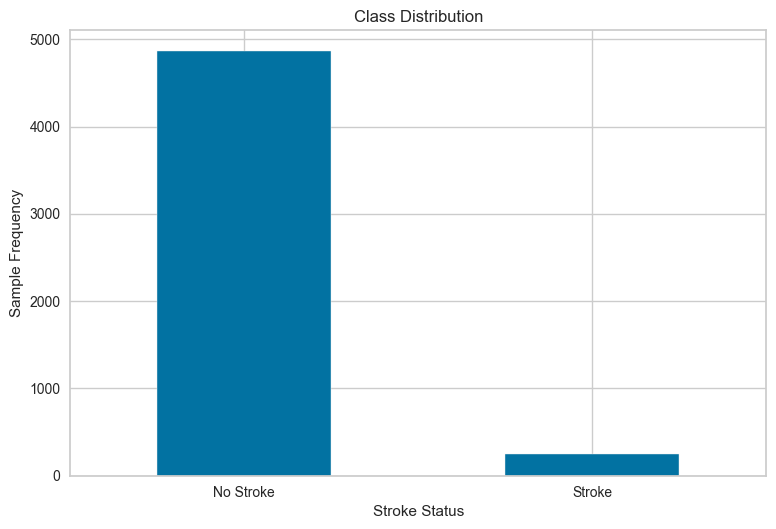

In [9]:
df['stroke'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Stroke Status')
plt.ylabel('Sample Frequency')
plt.xticks([0, 1], ['No Stroke', 'Stroke'], rotation=0)  # 0 = No Stroke, 1 = Stroke
plt.show()


In [10]:
suggestions = data_cleaning_suggestions(df)

From the EDA, we have discovered that id is unique per data entry, and the dataset contains a significant imbalance between classes. With this knowledge, we now know:

* The ID field can be dropped as it will have no effect on the prediction
* We may benefit from SMOTE

## 3. Pre-Processing

In [11]:
#Dataset  before any pre-processing 
df

id    gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0        0             1            Yes       
1     51676  Female  61.0        0             0            Yes       
2     31112    Male  80.0        0             1            Yes       
3     60182  Female  49.0        0             0            Yes       
4      1665  Female  79.0        1             0            Yes       
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0        1             0            Yes       
5106  44873  Female  81.0        0             0            Yes       
5107  19723  Female  35.0        0             0            Yes       
5108  37544    Male  51.0        0             0            Yes       
5109  44679  Female  44.0        0             0            Yes       

       work_type    Residence_type  avg_glucose_level   bmi  smoking_status   \
0           Private      Urban           228.69        36.6  formerly smoked   
1     Self-employed      Rural           202.21         NaN     never smoked   
2           Private      Rural           105.92        32.5     never smoked   
3           Private      Urban           171.23        34.4           smokes   
4     Self-employed      Rural           174.12        24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private      Urban            83.75         NaN     never smoked   
5106  Self-employed      Urban           125.20        40.0     never smoked   
5107  Self-employed      Rural            82.99        30.6     never smoked   
5108        Private      Rural           166.29        25.6  formerly smoked   
5109       Govt_job      Urban            85.28        26.2          Unknown   

      stroke  
0        1    
1        1    
2        1    
3        1    
4        1    
...      ...  
5105     0    
5106     0    
5107     0    
5108     0    
5109     0    

[5110 rows x 12 columns]

#### Dropping ID attribute


In [12]:
#Drop ID attribute

# df.drop('id', axis=1, inplace=True)

#### Encoding values in training set

In [13]:
# get categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

#Encode categorical values
le = LabelEncoder()

for col in cat_cols:

    le.fit(df[col])
    df[col] = le.transform(df[col])

#### Comparing MICE and KNN imputation as a solution for missing BMI Data

In [ ]:
# Make a copy of the dataframe
df_multi = df.copy()
df_knn = df.copy()

# Define the imputers
multi_imputer = IterativeImputer(estimator=RandomForestRegressor(), initial_strategy='median', max_iter=10, random_state=0)
knn_imputer = KNNImputer(n_neighbors=15)

# Apply the imputers
df_multi[['bmi']] = multi_imputer.fit_transform(df_multi[['bmi']])
df_knn[['bmi']] = knn_imputer.fit_transform(df_knn[['bmi']])

# Compare original and imputed values
missing_bmi_indices = df[df['bmi'].isnull()].index
print("Original values:\n", df.loc[missing_bmi_indices, 'bmi'])
print("Multivariate imputation:\n", df_multi.loc[missing_bmi_indices, 'bmi'])
print("KNN imputation:\n", df_knn.loc[missing_bmi_indices, 'bmi'])

# Compare distributions
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
df['bmi'].dropna().hist(bins=30)
plt.title('Original')
plt.xlabel('BMI', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.subplot(1, 3, 2)
df_multi['bmi'].hist(bins=30)
plt.title('After Multivariate imputation')
plt.xlabel('BMI', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.subplot(1, 3, 3)
df_knn['bmi'].hist(bins=30)
plt.title('After KNN imputation')
plt.xlabel('BMI', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adjust the spacing
plt.subplots_adjust(wspace=0.5)

plt.show()


In [ ]:
I will be going forward with KNN imputation.

In [15]:
df['bmi'] = df_knn['bmi']

In [16]:
df

id    gender   age  hypertension  heart_disease  ever_married  \
0      9046     1    67.0        0             1              1        
1     51676     0    61.0        0             0              1        
2     31112     1    80.0        0             1              1        
3     60182     0    49.0        0             0              1        
4      1665     0    79.0        1             0              1        
...     ...     ...   ...           ...            ...           ...   
5105  18234     0    80.0        1             0              1        
5106  44873     0    81.0        0             0              1        
5107  19723     0    35.0        0             0              1        
5108  37544     1    51.0        0             0              1        
5109  44679     0    44.0        0             0              1        

      work_type  Residence_type  avg_glucose_level     bmi     smoking_status  \
0         2             1             228.69        36.600000         1         
1         3             0             202.21        28.893237         2         
2         2             0             105.92        32.500000         2         
3         2             1             171.23        34.400000         3         
4         3             0             174.12        24.000000         2         
...         ...             ...                ...        ...             ...   
5105      2             1              83.75        28.893237         2         
5106      3             1             125.20        40.000000         2         
5107      3             0              82.99        30.600000         2         
5108      2             0             166.29        25.600000         1         
5109      0             1              85.28        26.200000         0         

      stroke  
0        1    
1        1    
2        1    
3        1    
4        1    
...      ...  
5105     0    
5106     0    
5107     0    
5108     0    
5109     0    

[5110 rows x 12 columns]

### Visualizations

Correlation Analysis

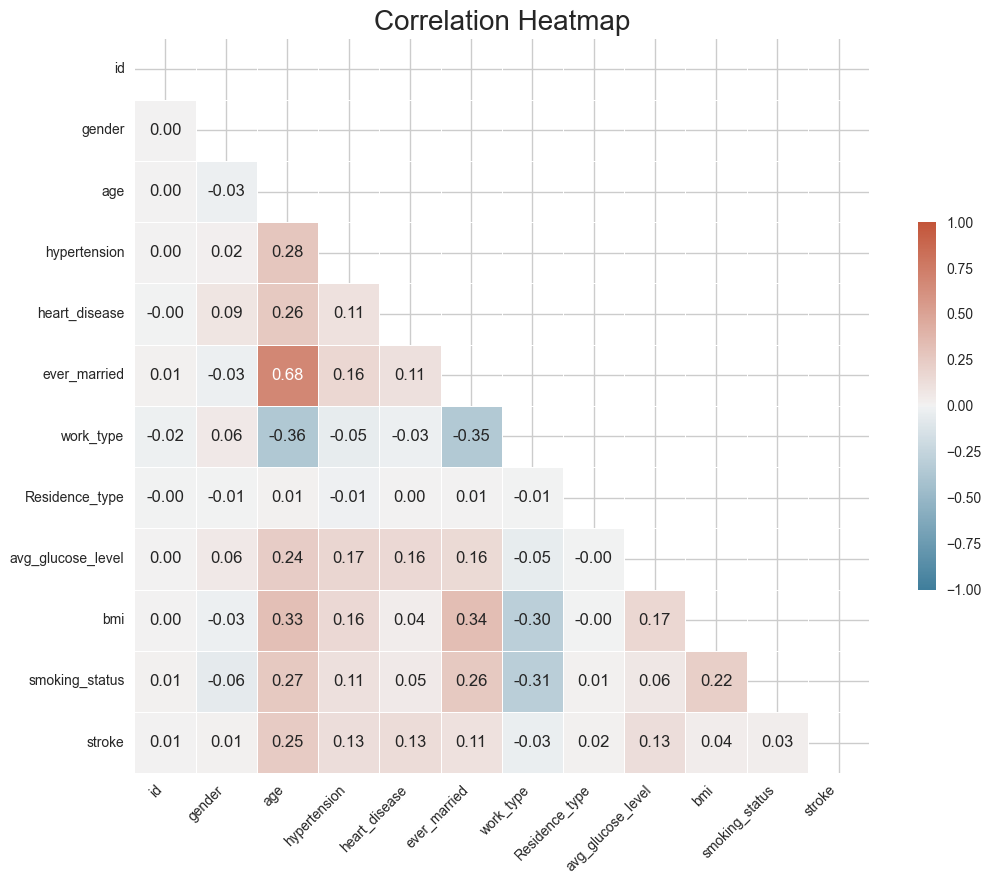

In [17]:
# Correlation matrix
corr_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f",
            vmax=1, vmin=-1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": .5})

# Set labels
ax.set_xticklabels(corr_matrix.columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(corr_matrix.columns)

plt.title('Correlation Heatmap', fontsize=20)
plt.tight_layout()
plt.show()

Pair Plot of Attributes

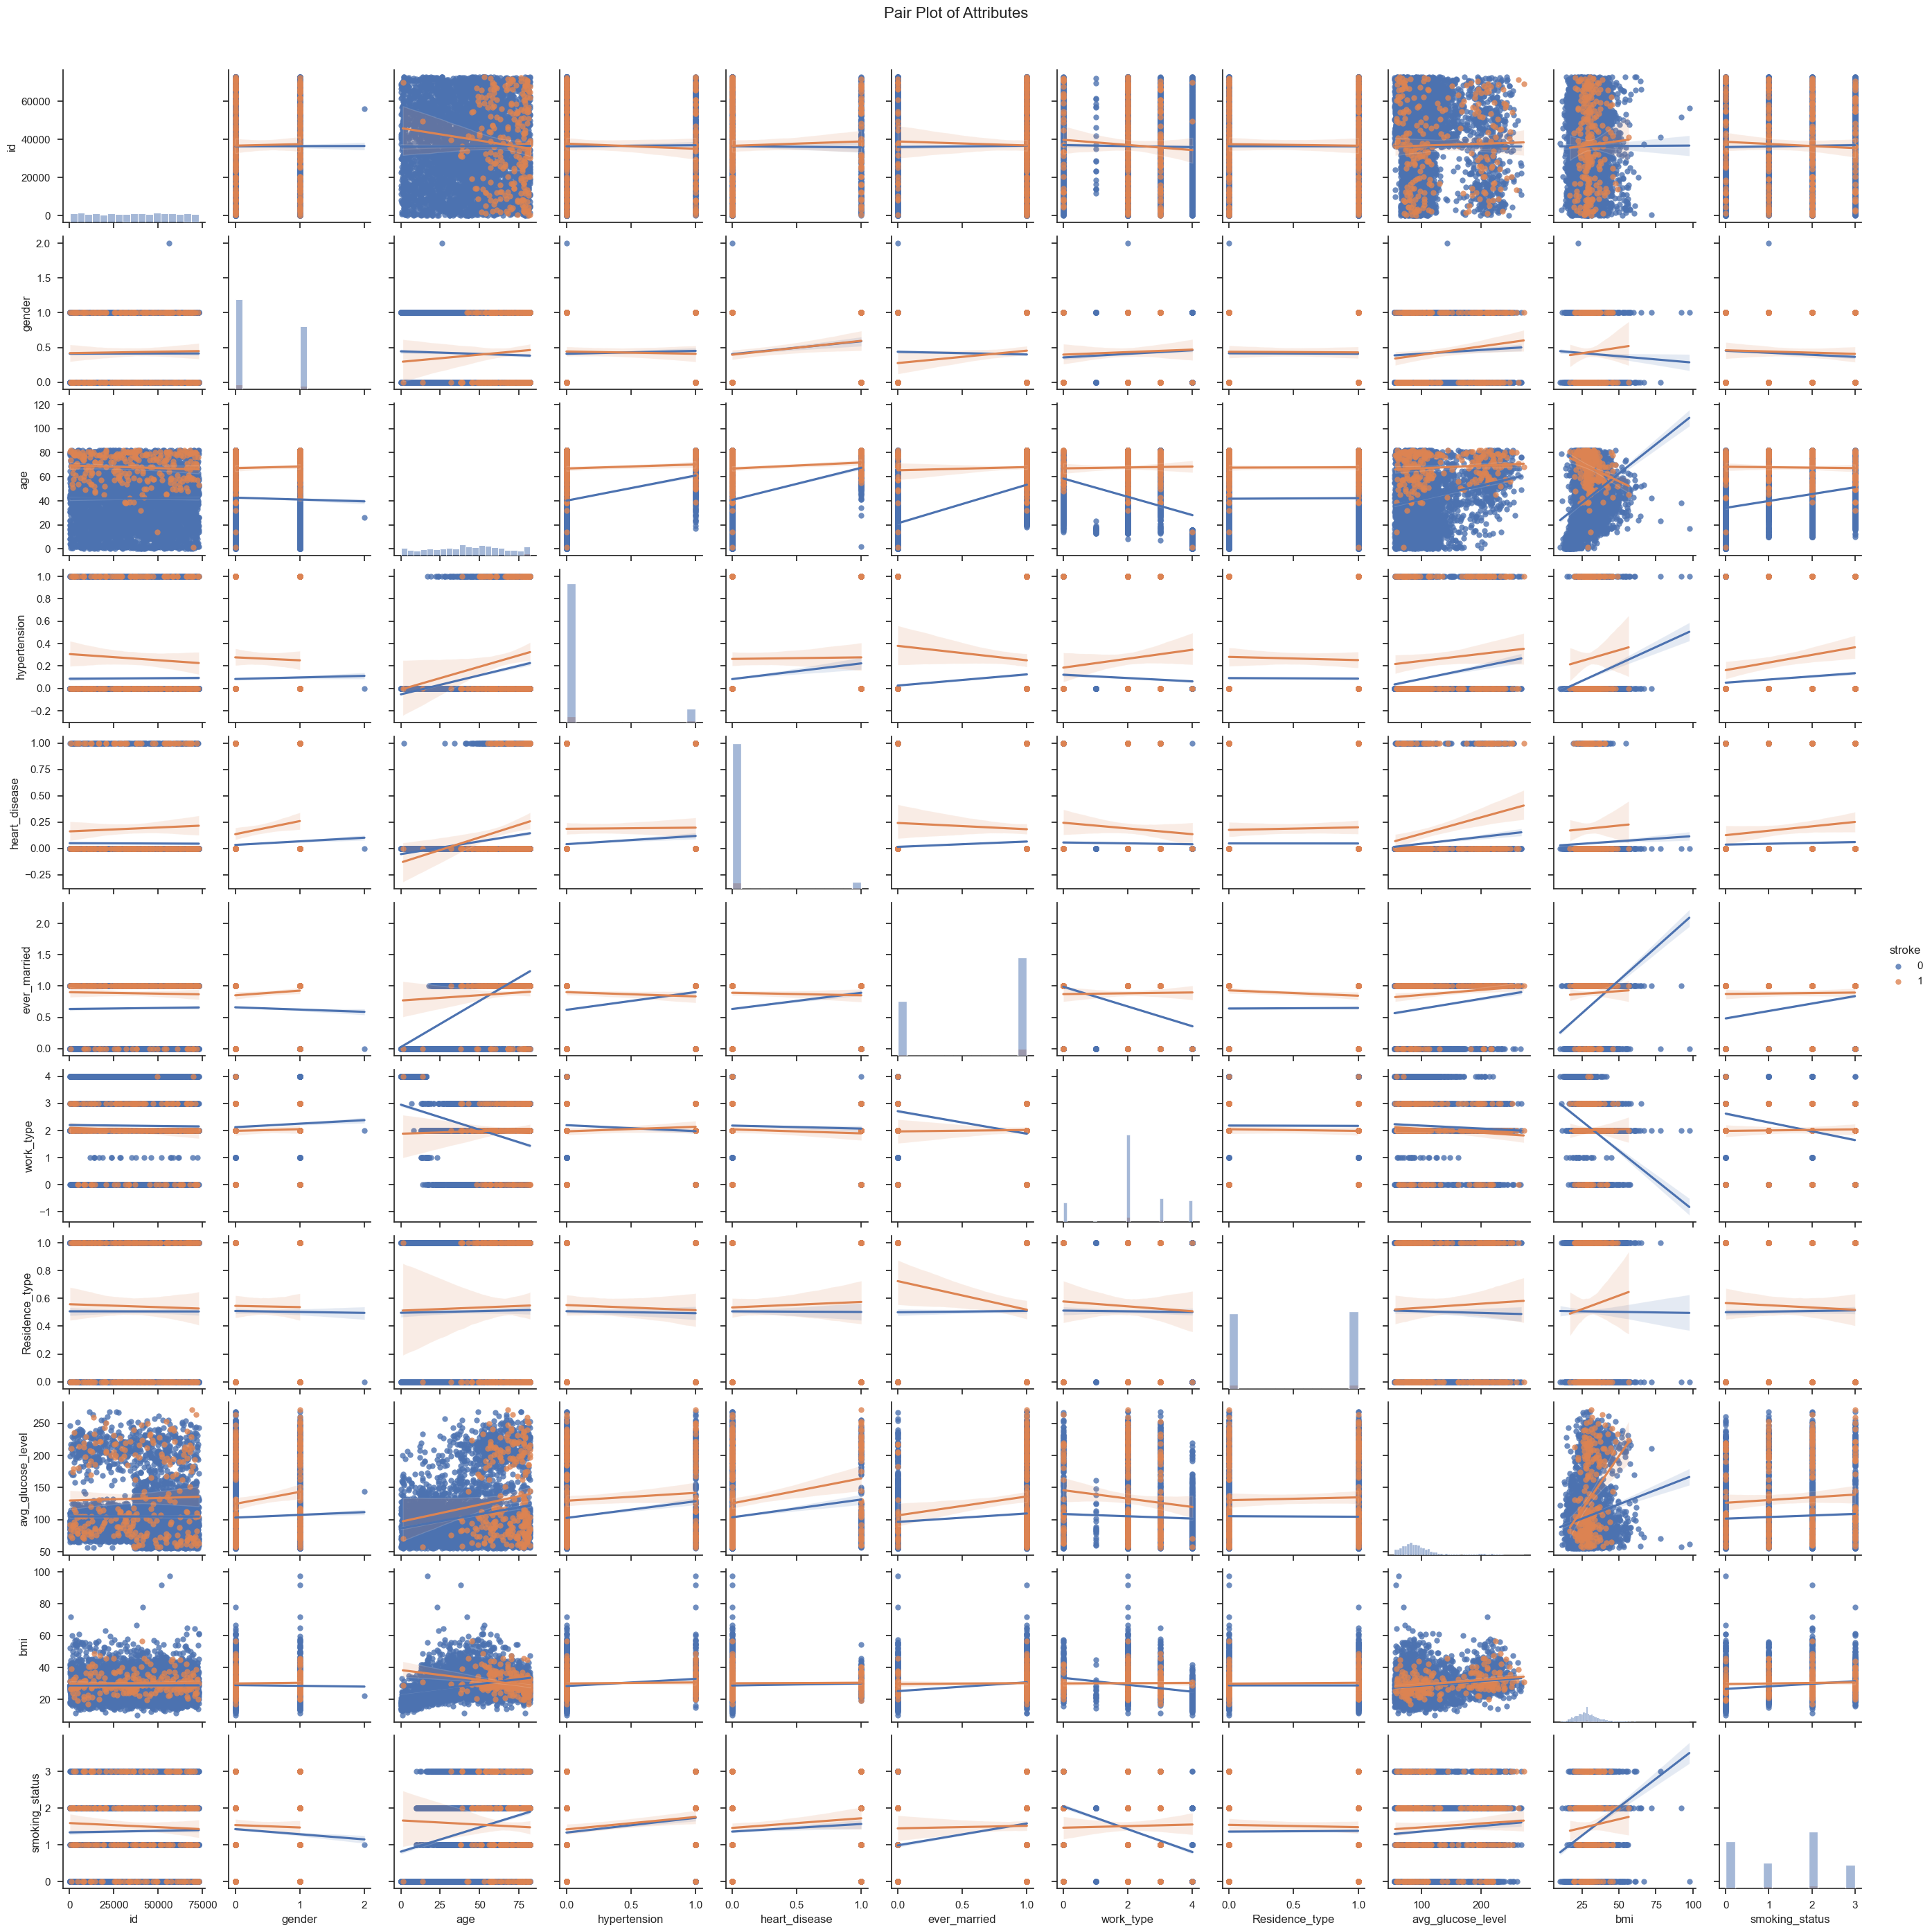

In [18]:
sns.set(style="ticks")
sns.pairplot(df, kind='reg', hue='stroke', diag_kind='hist')
plt.suptitle("Pair Plot of Attributes", y=1.02, fontsize=16)
plt.show()


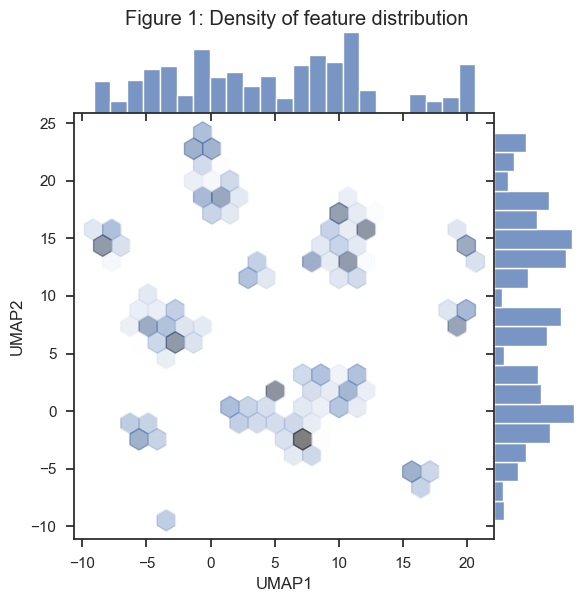

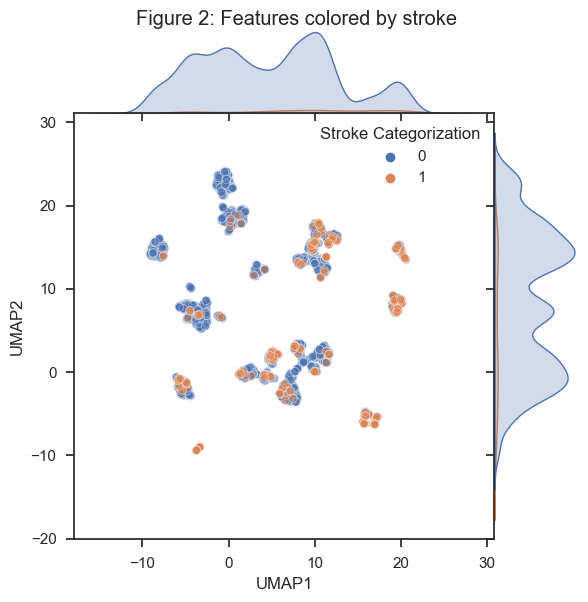

In [30]:
# Split data into labels and features
columns = df.columns.values
y_cols = df.columns.str.contains('id|stroke')

y = df[list(columns[y_cols])]
X = df[list(columns[~y_cols])]

# 1. Scale features
scaler = StandardScaler()
X_ = scaler.fit_transform(X)

# 2. Get embeddings
embedding = umap.UMAP().fit_transform(X_)

# Curate dataframe for plotting
X_to_plot = pd.DataFrame(embedding, columns=['UMAP1','UMAP2'])
X_to_plot['Stroke Categorization'] = y['stroke'].to_list()

X_to_plot = X_to_plot.sort_values(by='Stroke Categorization', ascending=True)

X_to_plot['id'] = y['id'].to_list()

p = sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                space= 0,
                alpha=0.5,
                kind='hex'
)
plt.suptitle("Figure 1: Density of feature distribution", y = 1)
plt.show()

sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                space= 0,
                alpha=0.5,
                hue='Stroke Categorization',
)

plt.suptitle("Figure 2: Features colored by stroke", y = 1)
plt.show()